In [1]:
import os
import cartopy.crs as ccrs
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import intake
import colormaps as cmaps
from colormaps.utils import concat
from matplotlib.colors import ListedColormap
mpl.rcParams['figure.dpi'] = 72

In [2]:
in_dir = '/pscratch/sd/w/wcmca1/GPM/healpix/'
# in_file = f'{in_dir}IMERG_V7_1H_zoom9_20200101_20200105.zarr'
# in_file = f'{in_dir}IMERG_V7_1H_zoom8_20200101_20200101.zarr'
# in_file = f'{in_dir}IMERG_V7_1H_zoom8_20200801_20200831.zarr'
in_file = f'{in_dir}IMERG_V7_6H_zoom8_20190101_20211231.zarr'
print(f"{in_file} exists: {os.path.exists(in_file)}")

# # Also check if zoom 8 exists for comparison
# zoom8_file = f'{in_dir}IMERG_V7_1H_zoom8_20200101_20200105.zarr'
# print(f"Zoom 8 file exists: {os.path.exists(zoom8_file)}")

/pscratch/sd/w/wcmca1/GPM/healpix/IMERG_V7_6H_zoom8_20190101_20211231.zarr exists: True


In [3]:
# Read data
ds = xr.open_zarr(in_file)
ds = ds.pipe(egh.attach_coords)
ds 

<xarray.Dataset> Size: 14GB
Dimensions:        (time: 4384, cell: 786432)
Coordinates:
  * time           (time) datetime64[ns] 35kB 2019-01-01T02:30:00 ... 2021-12...
    crs            int64 8B 0
  * cell           (cell) int32 3MB 0 1 2 3 4 ... 786428 786429 786430 786431
    lat            (cell) float64 6MB 89.82 89.82 89.82 ... -89.82 -89.82 -89.82
    lon            (cell) float64 6MB 45.0 135.0 225.0 ... 135.0 225.0 315.0
Data variables:
    precipitation  (time, cell) float32 14GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/13)
    coarsened_from_zoom:         9
    coarsening_factor:           4
    coarsening_method:           mean
    grid_mapping:                crs
    healpix_nest:                True
    healpix_npix:                3145728
    ...                          ...
    healpix_order:               9
    original_grid:               regular_lat_lon
    processing_timestamp:        2025-08-07T14:52:20.390877
    remapping_method:            delaunay_triangulation
    source_file:                 IMERG_V7_1H_zoom9_20190101_20211231.zarr
    temporal_coarsening_factor:  6

In [4]:
ds.time.isel(time=slice(0, 24))

<xarray.DataArray 'time' (time: 24)> Size: 192B
array(['2019-01-01T02:30:00.000000000', '2019-01-01T08:30:00.000000000',
       '2019-01-01T14:30:00.000000000', '2019-01-01T20:30:00.000000000',
       '2019-01-02T02:30:00.000000000', '2019-01-02T08:30:00.000000000',
       '2019-01-02T14:30:00.000000000', '2019-01-02T20:30:00.000000000',
       '2019-01-03T02:30:00.000000000', '2019-01-03T08:30:00.000000000',
       '2019-01-03T14:30:00.000000000', '2019-01-03T20:30:00.000000000',
       '2019-01-04T02:30:00.000000000', '2019-01-04T08:30:00.000000000',
       '2019-01-04T14:30:00.000000000', '2019-01-04T20:30:00.000000000',
       '2019-01-05T02:30:00.000000000', '2019-01-05T08:30:00.000000000',
       '2019-01-05T14:30:00.000000000', '2019-01-05T20:30:00.000000000',
       '2019-01-06T02:30:00.000000000', '2019-01-06T08:30:00.000000000',
       '2019-01-06T14:30:00.000000000', '2019-01-06T20:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 192B 2019-01-01T02:30:00 ... 2019-01-06T20...
    crs      int64 8B 0

In [5]:
# ds.time.dt.strftime('%Y')
ds.time.isel(time=0).dt.strftime('%Y-%m-%d %H:%M').item()

'2019-01-01 02:30'

<Figure size 460.8x345.6 with 0 Axes>

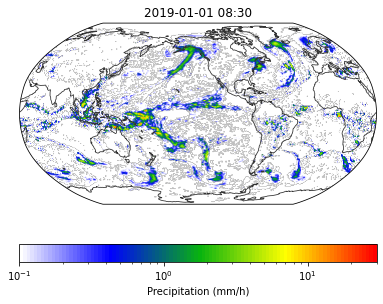

In [6]:
itime = 1
im = egh.healpix_show(ds.precipitation.isel(time=itime),norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
time_str = ds.time.isel(time=itime).dt.strftime('%Y-%m-%d %H:%M').item()
plt.title(time_str)
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/h)')

<Figure size 460.8x345.6 with 0 Axes>

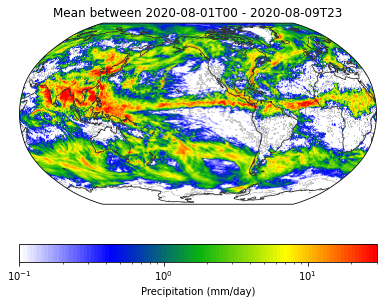

In [7]:
# time_str1 = '2019-06-01T00'
# time_str2 = '2019-08-31T23'
time_str1 = '2020-08-01T00'
time_str2 = '2020-08-09T23'
pcp_avg = ds.precipitation.sel(time=slice(time_str1, time_str2)).mean(dim='time') * 24
im = egh.healpix_show(pcp_avg,norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
plt.title(f'Mean between {time_str1} - {time_str2}')
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/day)')

<Figure size 460.8x345.6 with 0 Axes>

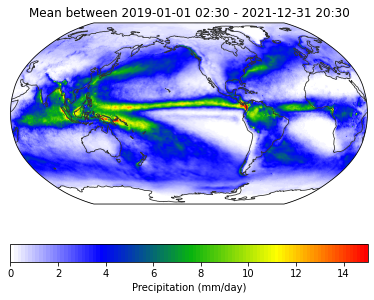

In [8]:
pcp_avg = ds.precipitation.mean(dim='time') * 24
im = egh.healpix_show(pcp_avg,norm=mpl.colors.Normalize(vmin=0, vmax=15), cmap=cmaps.WhBlGrYeRe)
time_str1 = ds.time.min().dt.strftime('%Y-%m-%d %H:%M').item()
time_str2 = ds.time.max().dt.strftime('%Y-%m-%d %H:%M').item()
plt.title(f'Mean between {time_str1} - {time_str2}')
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/day)')